<a href="https://colab.research.google.com/github/anishneema/HackGTproject/blob/main/FoodModelPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

In [41]:
data=pd.read_csv('train 3.csv')
center=pd.read_csv('fulfilment_center_info (1).csv')
meal=pd.read_csv('meal_info (1).csv')
test=pd.read_csv('test 3.csv')

In [6]:
print("The Shape of Demand dataset :",data.shape)
print("The Shape of Fulmilment Center Information dataset :",center.shape)
print("The Shape of Meal information dataset :",meal.shape)
print("The Shape of Test dataset :",test.shape)

The Shape of Demand dataset : (456548, 9)
The Shape of Fulmilment Center Information dataset : (77, 5)
The Shape of Meal information dataset : (51, 3)
The Shape of Test dataset : (32573, 8)


In [45]:
data = pd.concat([data, test], axis=0, ignore_index=True)

In [47]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177.0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0


In [48]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [49]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [50]:
data=data.merge(center,on='center_id',how='left')

In [51]:
data=data.merge(meal,on='meal_id',how='left')

In [54]:
print(set(data["category"]))

{'Beverages', 'Sandwich', 'Pizza', 'Extras', 'Desert', 'Starters', 'Seafood', 'Rice Bowl', 'Pasta', 'Biryani', 'Soup', 'Other Snacks', 'Fish', 'Salad'}


In [55]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0,Beverages,Indian


In [56]:
data.isna().sum()

,0
id,0
week,0
center_id,0
meal_id,0
checkout_price,0
base_price,0
emailer_for_promotion,0
homepage_featured,0
num_orders,32573
city_code,0


In [57]:
data['discount amount']=data['base_price']-data['checkout_price']

In [58]:
data['discount percent'] = ((data['base_price']-data['checkout_price'])/data['base_price'])*100

In [59]:
data['discount y/n'] = [1 if x>0 else 0 for x in (data['base_price']-data['checkout_price'])]

In [60]:
data=data.sort_values(['meal_id', 'week']).reset_index()

In [61]:
data = data.drop(columns=['meal_id'])

In [62]:
data.head()

,index,id,week,center_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount amount,discount percent,discount y/n
0,7,1499955,1,55,182.36,183.36,0,0,391.0,647,56,TYPE_C,2.0,Beverages,Italian,1.0,0.545375,1
1,40,1351400,1,24,184.36,182.36,0,0,514.0,614,85,TYPE_B,3.6,Beverages,Italian,-2.0,-1.096732,0
2,84,1057835,1,11,184.36,182.36,0,0,798.0,679,56,TYPE_A,3.7,Beverages,Italian,-2.0,-1.096732,0
3,125,1231510,1,83,170.78,170.78,0,0,284.0,659,77,TYPE_A,5.3,Beverages,Italian,0.0,0.000000,0
4,164,1402151,1,32,175.60,174.60,0,0,256.0,526,34,TYPE_A,3.8,Beverages,Italian,-1.0,-0.572738,0


In [63]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [64]:
data['city_code']=data['city_code'].astype('category')
data['region_code']=data['region_code'].astype('category')
data['category'] = data['category'].astype("category")
data['cuisine'] = data['cuisine'].astype("category")
data['center_type'] = data['center_type'].astype("category")

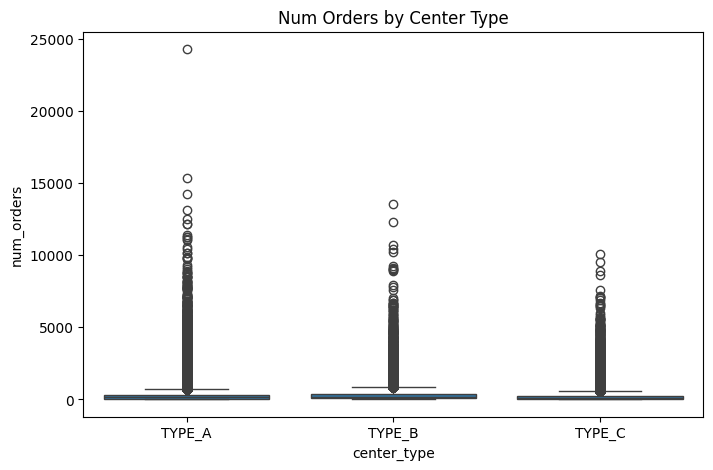

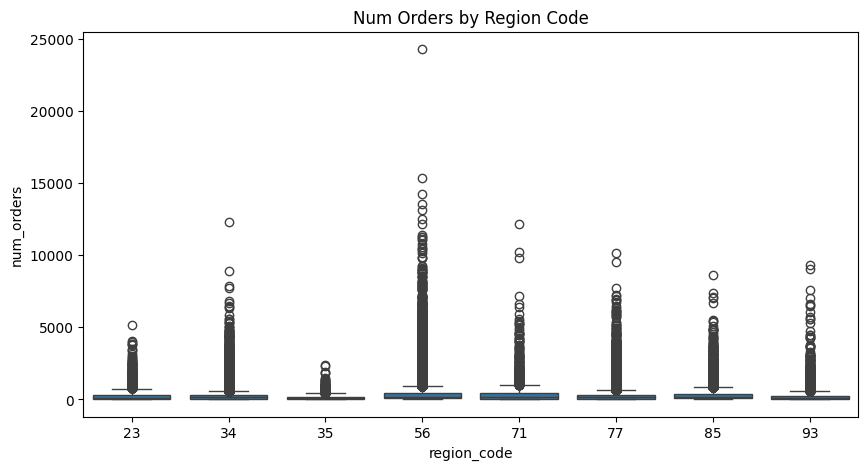

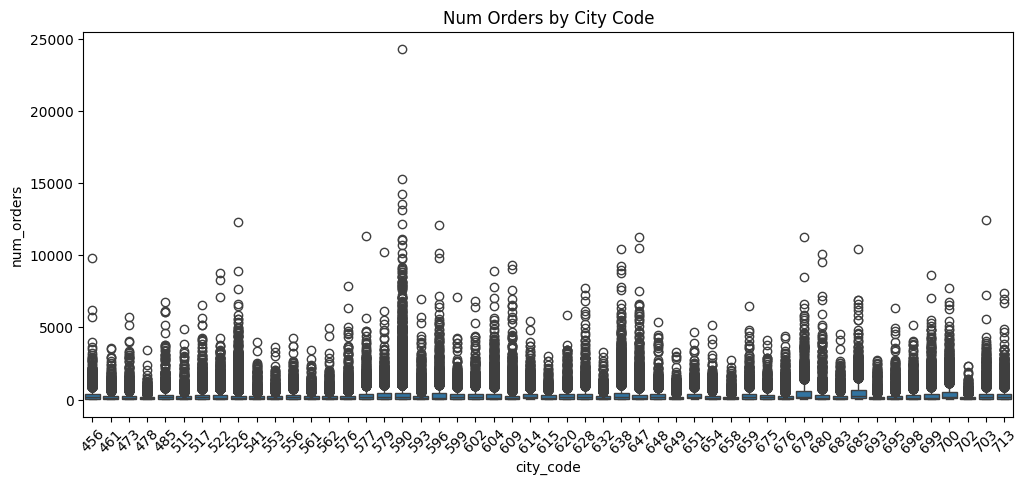

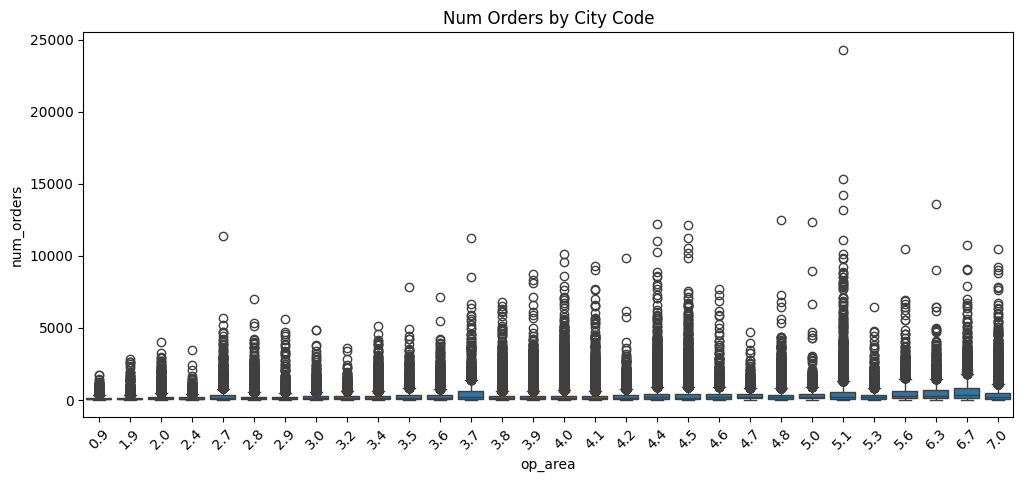

In [65]:
# Center type
plt.figure(figsize=(8,5))
sns.boxplot(x='center_type', y='num_orders', data=data)
plt.title("Num Orders by Center Type")
plt.show()

# Region code
plt.figure(figsize=(10,5))
sns.boxplot(x='region_code', y='num_orders', data=data)
plt.title("Num Orders by Region Code")
plt.show()

# City code
plt.figure(figsize=(12,5))
sns.boxplot(x='city_code', y='num_orders', data=data)
plt.title("Num Orders by City Code")
plt.xticks(rotation=45)
plt.show()

# OA code
plt.figure(figsize=(12,5))
sns.boxplot(x='op_area', y='num_orders', data=data)
plt.title("Num Orders by City Code")
plt.xticks(rotation=45)
plt.show()

In [66]:
data['index']

,index
0,7
1,40
2,84
3,125
4,164
...,...
489116,488829
489117,488871
489118,488919
489119,489003


In [67]:
data = data.drop(['index', 'op_area', 'region_code', "center_id", "city_code"], axis = 1)

In [68]:
data = data.dropna()

In [69]:
X = data.drop(columns = ["num_orders", "week", "id"])
y = data["num_orders"]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [71]:
X_train.head()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,center_type,category,cuisine,discount amount,discount percent,discount y/n
412582,280.33,282.33,0,0,TYPE_A,Starters,Thai,2.00,0.708391,1
143649,436.50,436.50,0,0,TYPE_B,Rice Bowl,Indian,0.00,0.000000,0
91372,532.53,658.63,0,0,TYPE_C,Seafood,Continental,126.10,19.145803,1
261894,503.43,505.43,0,0,TYPE_A,Pasta,Italian,2.00,0.395703,1
348990,339.50,445.23,0,0,TYPE_C,Desert,Indian,105.73,23.747277,1


In [72]:
xgb = XGBRegressor(
    max_depth = 5,
    min_child_weight = 1,
    objective='reg:squarederror',
    eval_metric='rmse',
    enable_categorical=True,
    tree_method="hist"
)

In [73]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.6292576557446001
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [74]:
xgb_grid.best_estimator_.fit(X_train,y_train)
pred = xgb_grid.best_estimator_.predict(X_test)

In [75]:
predictions = [round(value) for value in pred]
accuracy = accuracy_score(round(y_test), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 0.69%


In [76]:
import joblib

joblib.dump(xgb_grid.best_estimator_, "xgb_model.pkl")


['xgb_model.pkl']

In [36]:
print(set(data["cuisine"]))
print(set(data["category"]))

{'Indian', 'Italian', 'Thai', 'Continental'}
{'Beverages', 'Sandwich', 'Pizza', 'Extras', 'Desert', 'Starters', 'Seafood', 'Rice Bowl', 'Other Snacks', 'Pasta', 'Biryani', 'Soup', 'Fish', 'Salad'}
